3D simulations were run for the BOMEX (nonprecipitating shallow cumulus) case by Peter Blossey. I was told the 3D output is hourly. I copied and extracted the archived data, and derived new datasets including only vertical velocity, liquid water potential temperature, and total water. Note that precipitating water is not counted for total water in this case, but this shouldn't matter (since this is a nonprecipitating shallow cumulus case). I also assume that all non-precipitating condensate is water (even though this output includes ice), with the reasoning that ice cloud should not be present in the BOMEX case.

 Liquid water potential temperature is determined using the approximation $$\theta_l \approx \theta - \frac{L_v}{c_{pd}} r_L$$

Where the latent heat of vaporizaton of water $L_v$ is taken to be its value at 0 Celcius (2.501 x 10^6 J/kg), and $\theta$ is potential temperature, given by $$\theta = T (\frac{P_0}{P})^{R_d/{c_{pd}}}$$ where $P$ is pressure and $P_0$ is reference pressure (10^5 Pa).

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from subprocess import call
from tempfile import TemporaryFile
from glob import glob
import os
%matplotlib inline

In [2]:
Lv0 = 2.501e6  # Latent heat of vaporization for water at 0 Celsius (J/kg)
Cpd = 1005.  # Specific heat of dry air at constant pressure (J/kg/K)

def derive_hoc_dataset(original_dataset):
    """Takes in an xarray Dataset containing SAM 3D snapshot output, and returns a dataset
       containing liquid water potential temperature, total water mixing ratio, and
       vertical velocity in addition to the original variables.
    """
    dataset = original_dataset.copy(deep=True)
    theta = dataset['TABS'] * (1e3 / dataset['p']) ** (2./7.)  # SAM gives pressure in hPa
    dataset['thetal'] = theta - Lv0/Cpd * dataset['QN'] * 1e-3  # SAM gives QN in g/kg
    dataset['thetal'].attrs['units'] = 'K'
    dataset['thetal'].attrs['long_name'] = 'liquid water potential temperature'
    dataset['qt'] = dataset['Q'] + dataset['QN']
    dataset['qt'].attrs['units'] = 'g/kg'
    dataset['qt'].attrs['long_name'] = 'total water mixing ratio'
    dataset.rename({'W': 'w'}, inplace=True)
    return dataset

In [3]:
archive_folder = '/home/disk/eos1/bloss/Runs/BOMEX/DATA3D/'
netcdf_folder = '/home/disk/eos4/mcgibbon/nobackup/HOC/data/BOMEX/'

In [ ]:
for gzipped_filename in glob(archive_folder + '*sst_bmx3_16_*.nc.gz')[:20]:
    netcdf_filename = gzipped_filename[:-3].replace(archive_folder, netcdf_folder)  # remove the '.gz', switch folder
    if not os.path.isfile(netcdf_filename):  # check if the file has already been processed
        with open(netcdf_filename, 'w') as output_file:
            #print('Unzipping {} to {}'.format(gzipped_filename, netcdf_filename))
            call(['gunzip', '-c', gzipped_filename], stdout=output_file)
        with xr.open_dataset(netcdf_filename) as original_dataset:
            new_dataset = derive_hoc_dataset(original_dataset)
            new_dataset.drop(['U', 'V', 'TABS'])
        new_dataset.to_netcdf(netcdf_filename, mode='w')  # overwrite the copied dataset

With this pre-processing step complete, I derived a dataset with the statistical moments and parameters that will be used as input and outputs for the neural network. Input moments are the same as have been used to fit the Lewellen-Yoh joint double Gaussian PDF: $\overline{w}$, $\overline{w'^2}$, $\overline{w'^3}$, $\overline{\theta_l}$, $\overline{\theta_l'^2}$, $\overline{\theta_l'^3}$, $\overline{q_t}$, $\overline{q_t'^2}$, $\overline{q_t'^3}$, $\overline{w'q_t'}$, $\overline{w'\theta_l'}$, and $\overline{q_t'\theta_l'}$. For this initial test, only mean liquid water, $\overline{q_l}$, will be used as an output. SAM's "nonprecipitating water" is used as a measure of liquid water.

In [ ]:
def get_moments(array, n_max=3):
    """Takes in a DataArray and returns its statistical moments up to order n_max."""
    mean = array.mean(dim=('nx', 'ny'))
    return_list = [mean]
    perturbation = array - mean
    for moment_order in range(1, n_max):
        return_list.append((perturbation**moment_order).mean(dim=('nx', 'ny')))
    return return_list

def get_eddy_covariance(array1, array2):
    """Takes in two DataArrays and returns bar(array1' * array2')"""
    mean1 = array1.mean(dim=('nx', 'ny'))
    mean2 = array2.mean(dim=('nx', 'ny'))
    perturbation1 = array1 - mean1
    perturbation2 = array2 - mean2
    return (perturbation1 * perturbation2).mean(dim=('nx', 'ny'))

In [ ]:
snapshot_filenames = glob(netcdf_folder + '*sst_bmx3_16_*.nc')
with xr.open_dataset(snapshot_filenames[0]) as sample_snapshot:
    z = sample_snapshot['z'].copy(deep=True)

ntime = len(snapshot_filenames)
nz = len(z)
time = np.zeros([ntime])

base_vars = ['w', 'thetal', 'qt']

output_moments = []
for base_varname in base_vars:
    # want variable names for the mean, second moment, and third moment
    output_moments.extend([base_varname, base_varname + '2', base_varname + '3'])

data = {}
for varname in output_moments + ['w_qt', 'w_thetal', 'qt_thetal', 'ql']:
    data[varname] = np.zeros([ntime, nz])

for it, snapshot_filename in enumerate(snapshot_filenames):
    with xr.open_dataset(snapshot_filename) as snapshot:
        for base_varname in base_vars:
            v, v2, v3 = get_moments(snapshot[base_varname], n_max=3)
            data[base_varname][it, :] = v
            data[base_varname + '2'][it, :] = v2
            data[base_varname + '3'][it, :] = v3
            time[it] = snapshot['time'][0]

        data['w_qt'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['qt'])
        data['w_thetal'][it, :] = get_eddy_covariance(snapshot['w'], snapshot['thetal'])
        data['qt_thetal'][it, :] = get_eddy_covariance(snapshot['qt'], snapshot['thetal'])
        
        data['ql'][it, :] = get_moments(snapshot['QN'], n_max=1)[0]

In [ ]:
coords = {'time': (['time'], time), 'z': (['z'], z)}
data_vars = {}
for varname in data:
    data_vars[varname] = (['time', 'z'], data[varname])
ds = xr.Dataset(data_vars, coords=coords)
ds.to_netcdf(os.path.join(netcdf_folder, 'moments.nc'))

With statistical moments in hand, I defined a random forest to train. Scikit-learn was used for this purpose.

In [4]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(0)  # seed so results are reproduceable
model = RandomForestRegressor(n_estimators=50)

In [5]:
ds = xr.open_dataset(os.path.join(netcdf_folder, 'moments.nc'))
num_samples = len(ds['time'])*len(ds['z'])

input_parameters = ['w', 'w2', 'w3', 'thetal', 'thetal2', 'thetal3', 'qt', 'qt2', 'qt3', 'w_thetal', 'w_qt', 'qt_thetal']
output_parameters = ['ql']

model_input = np.zeros([num_samples, len(input_parameters)])
model_output = np.zeros([num_samples, len(output_parameters)])

for i, input_parameter in enumerate(input_parameters):
    model_input[:, i] = ds[input_parameter].values.reshape([num_samples])

for i, output_parameter in enumerate(output_parameters):
    model_output[:, i] = ds[output_parameter].values.reshape([num_samples])

Data was normalized to lie between 0 and 1, based on the training dataset.

In [6]:
def get_normalization(data):
    min_value = data.min(axis=0)
    max_value = data.max(axis=0)
    def normalize(data):
        return (data - min_value)/(max_value - min_value)
    def denormalize(data):
        return data * (max_value - min_value) + min_value
    return normalize, denormalize

normalize_input, denormalize_input = get_normalization(model_input)
normalize_output, denormalize_output = get_normalization(model_output)
model_input = normalize_input(model_input)
model_output = normalize_output(model_output)

In [7]:
total_samples = model_input.shape[0]
training_proportion = 0.8
training_samples = int(training_proportion*total_samples)
training_indices = np.random.choice(range(total_samples), size=training_samples, replace=False)
test_indices = list(range(total_samples))
for index in training_indices:
    test_indices.remove(index)

training_input = model_input[training_indices, :]
training_output = model_output[training_indices, :]
test_input = model_input[test_indices, :]
test_output = model_output[test_indices, :]

In [8]:
model.fit(training_input, training_output[:, 0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Having trained the neural network on the input data, I tested it on the testing data and the training data. Below we see a histogram of the model error on the test data (left) and the training data (right). Looking at the results from the testing data, the model error in general is quite small. From the frequency plot further below we can see that typical values of in-cloud liquid water are 5-8 x 10^-3 g/kg, while model errors are almost entirely below 0.6 x 10^-3 g/kg. It remains to be seen whether this is an improvement over other HOC approaches.

In [9]:
modeled_test_values = denormalize_output(model.predict(test_input))
actual_test_values = denormalize_output(test_output)
modeled_training_values = denormalize_output(model.predict(training_input))
actual_training_values = denormalize_output(training_output)

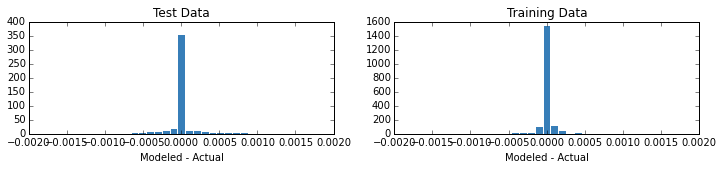

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].hist(modeled_test_values - actual_test_values[:, 0], bins=np.linspace(-0.002, 0.002, 40))
ax[0].set_xlabel('Modeled - Actual')
ax[0].set_title('Test Data')
ax[0].set_xlim(-0.002, 0.002)

ax[1].hist(modeled_training_values - actual_training_values[:, 0], bins=np.linspace(-0.002, 0.002, 40))
ax[1].set_xlabel('Modeled - Actual')
ax[1].set_title('Training Data')
ax[1].set_xlim(-0.002, 0.002)
plt.show()

Looking at the real and modeled PDF of liquid water, we see that the model reasonably represents the structure of the PDF. The model does perform better on the training data than the testing data, but the discrepancy is not large enough to suggest over-fitting.

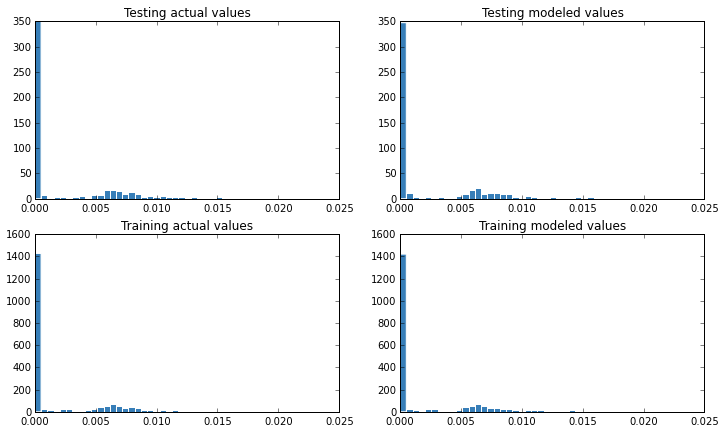

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12, 7))
ax[0, 0].hist(actual_test_values, bins=np.linspace(0, 0.02, 40))
ax[0, 0].set_title('Testing actual values')

ax[0, 1].hist(modeled_test_values, bins=np.linspace(0, 0.02, 40))
ax[0, 1].set_title('Testing modeled values')

ax[1, 0].hist(actual_training_values, bins=np.linspace(0, 0.02, 40))
ax[1, 0].set_title('Training actual values')

ax[1, 1].hist(modeled_training_values, bins=np.linspace(0, 0.02, 40))
ax[1, 1].set_title('Training modeled values')
plt.show()

## Sandbox

Below is a cell that contains the full process of defining, fitting, and evaluating a random forest model. This is here so that sensitivity to model parameters can be manually tested.

In [ ]:
model = RandomForestRegressor(n_estimators=10, max_depth=20, min_samples_leaf=4)
model.fit(training_input, training_output[:, 0])
modeled_test_values = denormalize_output(model.predict(test_input))
actual_test_values = denormalize_output(test_output)
modeled_training_values = denormalize_output(model.predict(training_input))
actual_training_values = denormalize_output(training_output)

v_min, v_max = -0.001, 0.001
fig, ax = plt.subplots(1, 2, figsize=(12, 2))
ax[0].hist(modeled_test_values - actual_test_values[:, 0], bins=np.linspace(v_min, v_max, 40))
ax[0].set_xlabel('Modeled - Actual')
ax[0].set_title('Test Data')
ax[0].set_xlim(v_min, v_max)

ax[1].hist(modeled_training_values - actual_training_values[:, 0], bins=np.linspace(v_min, v_max, 40))
ax[1].set_xlabel('Modeled - Actual')
ax[1].set_title('Training Data')
ax[1].set_xlim(v_min, v_max)

fig, ax = plt.subplots(2,2, figsize=(12, 7))
ax[0, 0].hist(actual_test_values, bins=np.linspace(0, 0.02, 50))
ax[0, 0].set_title('Testing actual values')

ax[0, 1].hist(modeled_test_values, bins=np.linspace(0, 0.02, 50))
ax[0, 1].set_title('Testing modeled values')

ax[1, 0].hist(actual_training_values, bins=np.linspace(0, 0.02, 50))
ax[1, 0].set_title('Training actual values')

ax[1, 1].hist(modeled_training_values, bins=np.linspace(0, 0.02, 50))
ax[1, 1].set_title('Training modeled values')
plt.show()